In [1]:
pwd

'/Users/edwardterrell/Desktop/Training/kindle/strava'

In [2]:
import requests
import json
import time
import os
from pprint import pprint

import pandas as pd
pd.set_option('display.precision', 1)
import warnings
warnings.filterwarnings("ignore", message=".*will drop timezone.*")

%matplotlib inline
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

%load_ext autoreload
%autoreload 2
from clean_convert import cleanup, convert_speed, order_columns
from zones import get_zones_for_id

# import graphics programs
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize':(14,6)}) # for all future plots

import sys
sys.executable

'/Users/edwardterrell/opt/anaconda3/envs/mlml/bin/python'

In [3]:
from token_manager import get_valid_access_token
import requests

access_token = get_valid_access_token()
print("Using access token:", access_token)

# Make an authenticated API call
response = requests.get(
    'https://www.strava.com/api/v3/athlete',
    headers={'Authorization': f'Bearer {access_token}'}
)
print(response.json())

Access token expired. Refreshing...
Using access token: b0e9954f4f5dd2f73ccd2d19626fbe82b6d069e6
{'id': 723727, 'username': 'eterrell', 'resource_state': 2, 'firstname': 'Ed', 'lastname': 'Terrell', 'bio': '', 'city': 'Boulder', 'state': 'CO', 'country': 'United States', 'sex': 'M', 'premium': True, 'summit': True, 'created_at': '2012-07-05T00:04:09Z', 'updated_at': '2025-07-09T12:38:59Z', 'badge_type_id': 1, 'weight': 61.235, 'profile_medium': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/723727/20826329/1/medium.jpg', 'profile': 'https://dgalywyr863hv.cloudfront.net/pictures/athletes/723727/20826329/1/large.jpg', 'friend': None, 'follower': None}


In [4]:
strava_df = pd.read_pickle("strava_data.pkl")
strava_zone_df = pd.read_pickle("strava_zone_data.pkl")

### Historical strava data

In [5]:
# Get activities from Jan 1, 2025 onward
start_date = int(time.mktime(time.strptime('2025-01-01', '%Y-%m-%d')))

url = "https://www.strava.com/api/v3/athlete/activities"
headers = {"Authorization": f"Bearer {access_token}"}
params = {
    "after": start_date,
    "per_page": 200,  # max per request
    "page": 1
}
activities = []
while True:
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    if not data:
        break
    activities.extend(data)
    params["page"] += 1


# Build out strava_df with only the necessary columns
strava_df = pd.DataFrame(activities)
cols_needed = ['id','name', 'distance', 'moving_time','total_elevation_gain', 'sport_type',
          'average_speed', 'average_heartrate','max_heartrate', 'suffer_score','start_date']
strava_df = strava_df.loc[:,cols_needed]
strava_df = strava_df.sort_values('start_date',ascending=False) 
strava_df.head()

,id,name,distance,moving_time,total_elevation_gain,sport_type,average_speed,average_heartrate,max_heartrate,suffer_score,start_date
127,15093410751,Gross Reservoir Loop Hwy72 - CR97 and Magnolia,90130.9,19673,1917.2,Ride,4.6,113.3,141.0,233.0,2025-07-12T13:45:47Z
126,15061307314,Nederland exploration and exploitation,54140.4,11638,993.7,Ride,4.7,109.1,131.0,106.0,2025-07-09T14:17:28Z
125,15048399185,Jamestown and eats at Lucky's Bakery,60380.4,9467,757.0,Ride,6.4,110.9,140.0,101.0,2025-07-08T14:44:02Z
124,15037283785,Old Stage,44640.8,7128,430.0,Ride,6.3,109.6,134.0,54.0,2025-07-07T12:38:38Z
123,15027982989,North dirt roads to Longmont bike paths and Ba...,59511.9,10021,361.6,Ride,5.9,102.5,129.0,47.0,2025-07-06T14:14:42Z


### Recent activities only!

In [74]:
# Get activities from month start
start_date = int(time.mktime(time.strptime('2025-07-01', '%Y-%m-%d')))

url = "https://www.strava.com/api/v3/athlete/activities"
headers = {"Authorization": f"Bearer {access_token}"}
params = {
    "after": start_date,
    "per_page": 200,  # max per request
    "page": 1
}
activities = []
while True:
    response = requests.get(url, headers=headers, params=params)
    data = response.json()
    if not data:
        break
    activities.extend(data)
    params["page"] += 1

# Build out strava_df with only the necessary columns
recent_df = pd.DataFrame(activities)
cols_needed = ['id','name', 'distance', 'moving_time','total_elevation_gain', 'sport_type',
          'average_speed', 'average_heartrate','max_heartrate', 'suffer_score','start_date']
recent_df = recent_df.loc[:,cols_needed]
recent_df = recent_df.sort_values('start_date',ascending=False) 

new_activities_df = recent_df[~recent_df.id.isin(strava_df.id)].copy()
new_activities_df

In [76]:
new_activities_df = cleanup (new_activities_df)
new_activities_df['converted_speed'] = new_activities_df.apply(convert_speed, axis=1)
new_activities_df = order_columns(new_activities_df)
new_activities_df

,id,name,date,sport,distance,time,speed,elev_gain,avg_HR,max_HR,suffer_score,time-minutes,average_speed,start_date
8,15102156207,Recovery gravel in the early morning,2025-07-13,Ride,26.7,2:04,12.8,1043.0,108.3,154.0,52.0,125.0,5.7,2025-07-13 13:09:14+00:00


### Recent zone data

In [162]:
new_activities_df

,id,name,date,sport,distance,time,speed,elev_gain,avg_HR,max_HR,suffer_score,time-minutes,average_speed,start_date
8,15102156207,Recovery gravel in the early morning,2025-07-13,Ride,26.7,2:04,12.8,1043.0,108.3,154.0,52.0,125.0,5.7,2025-07-13 13:09:14+00:00


In [163]:
# Create a new_zone dataframe for recent activities
cols = ['id', 'name', 'date', 'suffer_score','start_date']
new_data = new_activities_df.loc[:,cols]
new_zone_df = pd.DataFrame(new_data, columns=cols)
new_zone_df

,id,name,date,suffer_score,start_date
8,15102156207,Recovery gravel in the early morning,2025-07-13,52.0,2025-07-13 13:09:14+00:00


In [164]:
zone = new_zone_df['id'].apply(lambda current_id: get_zones_for_id(current_id, access_token))
zone.index = new_zone_df['id']

Fetching zones for activity: 15102156207


In [165]:
# Add in summary zones: moderate and intense
zone['moderate'] = zone[['Zone1', 'Zone2']].sum(axis=1)
zone['intense'] = zone[['Zone3', 'Zone4', 'Zone5']].sum(axis=1)
zone

,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense
id,,,,,,,
15102156207,3.8,117.1,0.1,0.5,3.5,120.9,4.1


In [166]:
new_zone_df = pd.merge(new_zone_df, zone, left_on='id',right_index=True)
new_zone_df

,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense
8,15102156207,Recovery gravel in the early morning,2025-07-13,52.0,2025-07-13 13:09:14+00:00,3.8,117.1,0.1,0.5,3.5,120.9,4.1


In [167]:
# Get the Sunday start of the week for each date (time set to midnight)
new_zone_df['week_start'] = new_zone_df['start_date'].dt.to_period('W-SUN').dt.start_time

In [168]:
#new_zone_df.columns are now matched
new_zone_df = pd.concat ([new_zone_df, strava_zone_df], axis=0)

In [ ]:
new_zone_df.head(5)

In [170]:
only_cols = ['id', 'name', 'date', 'suffer_score', 'start_date', 'Zone1', 'Zone2',
       'Zone3', 'Zone4', 'Zone5', 'moderate', 'intense', 'week_start']
new_zone_df = new_zone_df[only_cols]
new_zone_df.head()

,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start
8,15102156207,Recovery gravel in the early morning,2025-07-13,52.0,2025-07-13 13:09:14+00:00,3.8,117.1,0.1,0.5,3.5,120.9,4.1,2025-07-07
127,15093410751,Gross Reservoir Loop Hwy72 - CR97 and Magnolia,2025-07-12,233.0,2025-07-12 13:45:47+00:00,22.3,222.0,82.0,1.6,0.0,244.3,83.6,2025-07-07
126,15061307314,Nederland exploration and exploitation,2025-07-09,106.0,2025-07-09 14:17:28+00:00,31.9,132.7,29.4,0.0,0.0,164.6,29.4,2025-07-07
125,15048399185,Jamestown and eats at Lucky's Bakery,2025-07-08,101.0,2025-07-08 14:44:02+00:00,21.4,109.4,26.1,0.8,0.0,130.8,26.9,2025-07-07
124,15037283785,Old Stage,2025-07-07,54.0,2025-07-07 12:38:38+00:00,2.6,104.8,11.4,0.0,0.0,107.3,11.4,2025-07-07


In [171]:
# Temporarily sort ascending by week_start and date to compute cumulative sum correctly
temp = new_zone_df.sort_values(['week_start', 'start_date'])

# Calculate cumulative sum within each week
cumulative_cols = ['intense', 'moderate', 'suffer_score']
cumulative_sums = (
    temp
    .groupby('week_start')[cumulative_cols]
    .cumsum()
    .add_prefix('weekly_')  # rename columns if needed
)
# Add start_date column for reference
cumulative_sums['start_date'] = temp['start_date']

In [172]:
cumulative_sums = cumulative_sums.sort_values('start_date', ascending = False)
cumulative_sums.head(3)

,weekly_intense,weekly_moderate,weekly_suffer_score,start_date
8,155.5,767.9,546.0,2025-07-13 13:09:14+00:00
127,151.4,647.0,494.0,2025-07-12 13:45:47+00:00
126,67.8,402.8,261.0,2025-07-09 14:17:28+00:00


In [174]:
strava_zone_df = pd.merge(new_zone_df,cumulative_sums, left_on ='start_date', right_on='start_date')

### Build strava_df from activities

In [ ]:
# drop activities where no heartrate data was collected
# strava_df = strava_df.dropna(subset=['average_heartrate'])

# process data with function cleanup (from clean_convert.py)
cleanup (strava_df)

# add column: converted_speed ride-mph  and run-min/mile  (from clean_convert.py)
strava_df['converted_speed'] = strava_df.apply(convert_speed, axis=1)

strava_df = order_columns(strava_df)
strava_df.head(2)

### Dataframe approach to create strava_zone_df

In [39]:
# Create a zone dataframe
cols = ['id', 'name', 'date', 'suffer_score','start_date']
#data = strava_df.iloc[:,[0,1,2,-4,-1]]
data = strava_df.loc[:,cols]
strava_zone_df = pd.DataFrame(data, columns=cols)
strava_zone_df.head(1)

,id,name,date,suffer_score,start_date
127,15093410751,Gross Reservoir Loop Hwy72 - CR97 and Magnolia,2025-07-12,233.0,2025-07-12 13:45:47+00:00


### Logging historical data

In [8]:
# This was to log historical data - DO NOT RUN -are you sure?
activity_ids = strava_df['id'].tolist()

# Split into two batches
batch1 = activity_ids[:64]
batch2 = activity_ids[64:]

# Process batch 1
zone_data_1 = [get_zones_for_id(current_id, access_token) for current_id in batch1]

# Sleep 15 minutes to avoid rate limit
print("Sleeping for 16 minutes to respect Strava rate limit...")
time.sleep(16 * 60)

# Process batch 2
zone_data_2 = [get_zones_for_id(current_id, access_token) for current_id in batch2]

In [42]:
# Combine results into one DataFrame
all_zone_data = zone_data_1 + zone_data_2
zone_df = pd.DataFrame(all_zone_data,index=batch1 + batch2 )

In [40]:
zone_df.head(2)

,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense
15093410751,22.3,222.0,82.0,1.6,0.0,244.3,83.6
15061307314,31.9,132.7,29.4,0.0,0.0,164.6,29.4


In [26]:
# Add in summary zones: moderate and intense
zone_df['moderate'] = zone_df[['Zone1', 'Zone2']].sum(axis=1)
zone_df['intense'] = zone_df[['Zone3', 'Zone4', 'Zone5']].sum(axis=1)

In [42]:
# merge both dfs
strava_zone_df = pd.merge(strava_zone_df, zone_df, left_on='id',right_index=True)

In [43]:
# Get the Sunday start of the week for each date (time set to midnight)
strava_zone_df['week_start'] = strava_zone_df['start_date'].dt.to_period('W-SUN').dt.start_time

In [44]:
# Temporarily sort ascending by week_start and date to compute cumulative sum correctly
temp = strava_zone_df.sort_values(['week_start', 'start_date'], ascending=[True, True])

# Calculate cumulative sum within each week
cumulative_cols = ['intense', 'moderate', 'suffer_score']
cumulative_sums = (
    temp
    .groupby('week_start')[cumulative_cols]
    .cumsum()
    .add_prefix('weekly_')  # rename columns if needed
)
strava_zone_df = strava_zone_df.join(cumulative_sums)

In [45]:
keep_cols = ['id', 'name', 'date', 'suffer_score', 'moderate', 'intense',
       'weekly_intense','weekly_moderate','weekly_suffer_score']

In [46]:
strava_zone_df[keep_cols].head(2)

,id,name,date,suffer_score,moderate,intense,weekly_intense,weekly_moderate,weekly_suffer_score
127,15093410751,Gross Reservoir Loop Hwy72 - CR97 and Magnolia,2025-07-12,233.0,244.3,83.6,151.4,647.0,494.0
126,15061307314,Nederland exploration and exploitation,2025-07-09,106.0,164.6,29.4,67.8,402.8,261.0


### New dataframes for plotting

In [175]:
week_summary = (
    strava_zone_df
    .groupby('week_start')[['weekly_intense','weekly_moderate','weekly_suffer_score']]
    .max()
    .reset_index()
)
# Format weeks as strings (e.g. 'Jul 01', 'Jul 08')
week_summary["week"] = week_summary["week_start"].dt.strftime('%b %d')
#week_summary[['weekly_intense','weekly_moderate']].head(3)

In [183]:
week_summary.sort_values('week_start',ascending=False).head()

,week_start,weekly_intense,weekly_moderate,weekly_suffer_score,week
26,2025-07-07,155.5,767.9,546.0,Jul 07
25,2025-06-30,143.9,794.7,597.0,Jun 30
24,2025-06-23,259.7,479.1,662.0,Jun 23
23,2025-06-16,240.2,554.1,668.0,Jun 16
22,2025-06-09,95.1,292.5,287.0,Jun 09


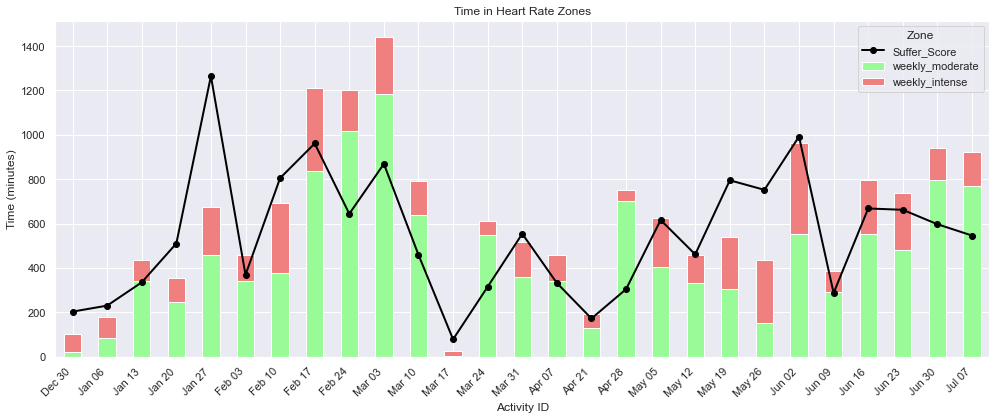

In [176]:
import matplotlib.pyplot as plt

ax = week_summary.plot(
    y=['weekly_moderate','weekly_intense'],
    x='week',
    kind='bar', 
    stacked=True, 
    figsize=(14, 6), 
    color=['#98FB98', '#F08080']
)

# Overlay line plot for 'weekly_suffer_score'
line = ax.plot(
    week_summary["week"],
    week_summary["weekly_suffer_score"],
    color="black",
    marker="o",
    linewidth=2,
    label="Suffer_Score"  
)

plt.title("Time in Heart Rate Zones")
plt.xlabel("Activity ID")
plt.ylabel("Time (minutes)")
plt.legend(title="Zone")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [21]:
# Melt the DataFrame to long format and plot
long_df = pd.melt(
    week_summary,
    id_vars="week",
    value_vars=["weekly_intense", "weekly_moderate"],
    var_name="zone",
    value_name="minutes"
)

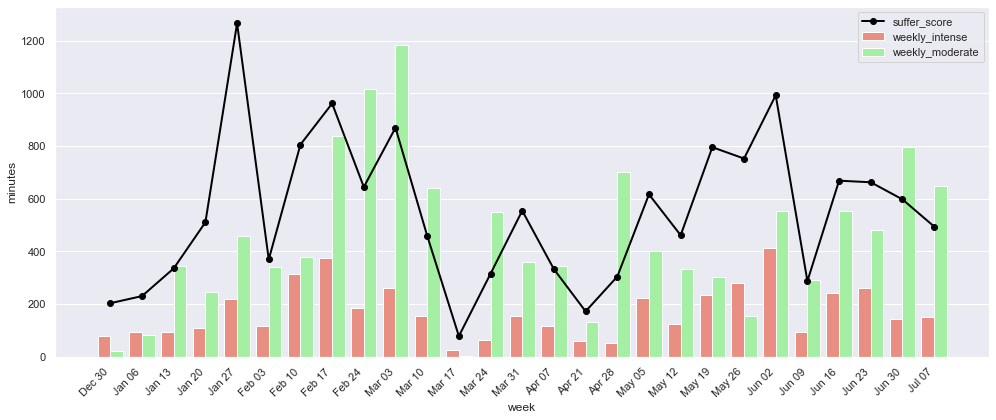

In [38]:
# Add a line plot on top 
plt.figure(figsize=(14, 6))
# Add line plot with a label
ax = sns.barplot(
    data=long_df,
    x="week",
    y="minutes",
    hue="zone",
    palette={"weekly_intense": "salmon", "weekly_moderate": "palegreen"}
)
line = ax.plot(
    week_summary["week"],
    week_summary["weekly_suffer_score"],
    color="black",
    marker="o",
    linewidth=2,
    label="suffer_score"  
)
# Create the legend manually from all handles
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, labels=labels)

# Optional: improve layout
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
#plt.legend()
plt.show()

In [38]:
strava_df.head(1)

,id,name,date,sport,distance,time,speed,elev_gain,avg_HR,max_HR,suffer_score,time-minutes,average_speed,start_date
127,15093410751,Gross Reservoir Loop Hwy72 - CR97 and Magnolia,2025-07-12,Ride,56.0,5:27,10.2,6290.0,113.3,141.0,233.0,327.9,4.6,2025-07-12 13:45:47+00:00


In [47]:
strava_zone_df.head(1)

,id,name,date,suffer_score,start_date,Zone1,Zone2,Zone3,Zone4,Zone5,moderate,intense,week_start,weekly_intense,weekly_moderate,weekly_suffer_score
127,15093410751,Gross Reservoir Loop Hwy72 - CR97 and Magnolia,2025-07-12,233.0,2025-07-12 13:45:47+00:00,22.3,222.0,82.0,1.6,0.0,244.3,83.6,2025-07-07,151.4,647.0,494.0


In [48]:
# Save both
strava_df.to_pickle("strava_data.pkl")
strava_zone_df.to_pickle("strava_zone_data.pkl")

print("All data saved.")

All data saved.
